In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [22]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../Dataset/TSLA_data.csv')
df1=df.reset_index()['Close']
df1

0        21.368668
1        21.150000
2        20.974667
3        21.105333
4        22.427334
           ...    
1830    252.350006
1831    254.110001
1832    241.550003
1833    241.369995
1834    227.500000
Name: Close, Length: 1835, dtype: float64

In [23]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [24]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [25]:
test_size

367

In [26]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [27]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
X_train.shape

(1367, 100, 1)

In [30]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0416 - val_loss: 0.0092
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0034 - val_loss: 0.0065
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/ste

In [32]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [33]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [34]:
y_pred.shape

(266, 1)

In [35]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
test_mae = np.mean(np.abs(ytest - y_pred))


print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 275.1759837425694
Testing MAPE: 54149.2109495704
Testing MAE: 263.0636348796415


In [36]:
## 13. Dự báo 90 ngày tiếp theo
x_input=test_data[220:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=146
i=0
while(i<90):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.49577786 0.48366063 0.5087713  0.51789663 0.52377356 0.51778977
 0.53112511 0.53362552 0.52591064 0.50667697 0.488811   0.50894227
 0.4891743  0.49701737 0.48964446 0.48477192 0.43995739 0.44286382
 0.44374003 0.44750128 0.44656096 0.44615491 0.44220133 0.44032069
 0.4310885  0.5311679  0.54978183 0.53550616 0.52911626 0.52490621
 0.50845075 0.50659147 0.49346981 0.51184869 0.59111291 0.60902163
 0.66097399 0.72247909 0.67651052 0.68025041 0.63951771 0.65990545
 0.69841557 0.71393078 0.70544658 0.70033899 0.72795    0.69809502
 0.69732571 0.68591372 0.71213564 0.73763096 0.72551377 0.7394261
 0.76413072 0.80629529 0.80751344 0.83144867 0.88226838 0.86801411
 0.90675934 0.96401162 1.         0.91509394 0.90663112 0.87433984
 0.89472759 0.9624302  0.94501303 0.89699288 0.86653952 0.83753936
 0.78505273 0.85164409 0.85294767 0.81727984 0.81851938 0.81809194
 0.83640671 0.82155399 0.88964133 0.85886742 0.88596555 0.88077247
 0.8616242  0.85579002 0.84339493 0.8232423  0.8252

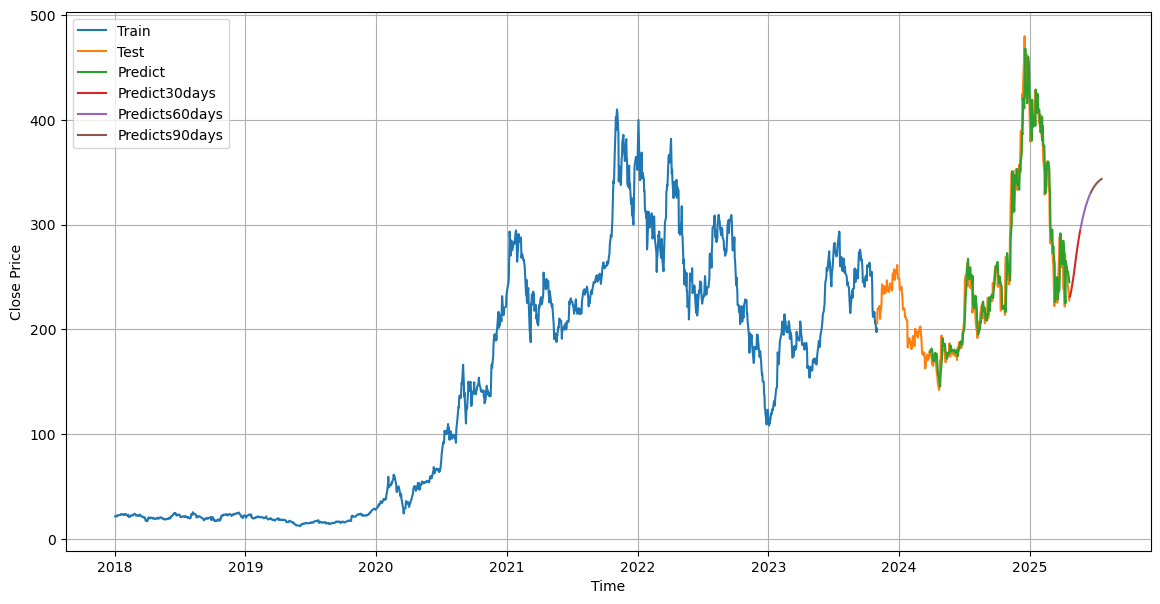

In [41]:
# 14. Vẽ hình có trục thời gian
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(14,7))

plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data))
plt.plot(df['Date'][train_size:train_size+test_size], scaler.inverse_transform(test_data))
plt.plot(df['Date'][train_size+101:train_size+test_size], y_pred)

last_date = df['Date'].iloc[-1]
predict_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
predict_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=31), periods=30)
predict_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=61), periods=30)

plt.plot(predict_dates_30, scaler.inverse_transform(lst_output[0:30]))
plt.plot(predict_dates_60, scaler.inverse_transform(lst_output[30:60]))
plt.plot(predict_dates_90, scaler.inverse_transform(lst_output[60:90]))

plt.legend(['Train','Test','Predict','Predict30days', 'Predicts60days', 'Predicts90days'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()
